In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from tqdm.auto import tqdm

from matplotlib import cm
import matplotlib.pyplot as plt

# Optimization for some chosen Y (no l2 normalization)

In [151]:
Y = torch.tensor([[0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0],
                  [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1]]).float()

c, n = Y.shape
d = c

X = torch.normal(0,0.1,size=(8,n), requires_grad=True)

optimizer = optim.SGD([X], lr=1e-2, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=500)
alpha = 0.97
beta  = 0.5

tracker   = {'loss' : [], 'x_svals' : []}
bar = tqdm(total=800, dynamic_ncols=True, desc='Train')
for i in range(800):
    optimizer.zero_grad()

    Z = torch.cat((Y, X), dim=0)

    z_svals = torch.linalg.svdvals(Z)
    x_svals = torch.linalg.svdvals(X)

    loss = z_svals.sum() - alpha*x_svals.sum() + beta*x_svals.max()**2
    
    loss.backward()
    tracker['loss'].append(loss.detach().item())
    tracker['x_svals'].append(x_svals.detach())
    optimizer.step()
    scheduler.step()
    bar.set_postfix(loss="{:1.5e}".format(loss.detach().item()),
                    lr="{:1.3e}".format(scheduler.optimizer.param_groups[0]['lr']))
    bar.update()
bar.close()
Y = Y.detach().cpu()
X = X.detach().cpu()
Z = Z.detach().cpu()

Train:   0%|          | 0/800 [00:00<?, ?it/s]

In [159]:
Y.shape

torch.Size([6, 27])

In [152]:
from scipy import optimize

mu = torch.linalg.svdvals(Y)
print(mu)
def curve(x):
    x = x[0]
    return [np.array([x / np.sqrt(m**2 + x**2) for m in mu]).sum() - len(mu)*alpha + 2.0 * beta * x]

def grad(x):
    x = x[0]
    return [np.array([m**2 / np.sqrt(m**2 + x**2)**3 for m in mu]).sum() + 2.0 * beta]

sol = optimize.root(curve, [0.0], jac=grad, method='hybr')
print("Singular values according to theory: {}".format(round(sol.x[0], 5)))

tensor([4.3850, 3.7486, 2.6830, 2.0510, 1.4345, 0.5065])
Singular values according to theory: 1.925


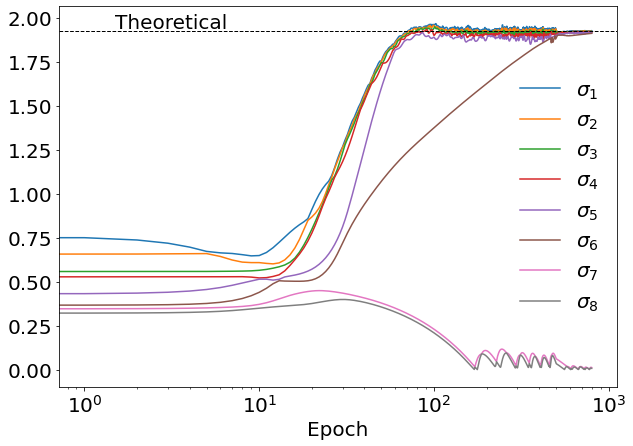

In [162]:
svals = torch.stack(tracker['x_svals'], dim=0)
f = plt.figure(figsize=(10,7))
for i in range(X.shape[0]):
    plt.plot(svals[:,i], linewidth=1.5)
plt.grid(alpha=0)
plt.xscale('log')
plt.xlabel("Epoch", fontsize=20)
plt.legend(["$\sigma_{}$".format(i) for i in range(1,X.shape[0]+1)], fontsize=20, frameon=False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(sol.x[0], linestyle='--', color='black', linewidth=1.0)
plt.text(1.5, sol.x[0] + 0.02, "Theoretical", fontsize=20)
f.savefig("./convergence.pdf", bbox_inches='tight')

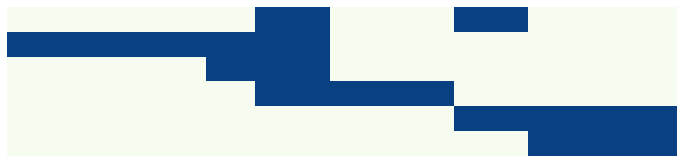

In [156]:
f = plt.figure(figsize=(12,10))
plt.imshow(Y, cmap="GnBu", vmin=0.0, vmax=1.0)
plt.axis('off')
plt.xlabel("Sample", fontsize=20)
plt.ylabel("Label", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
f.savefig("./y.pdf", bbox_inches='tight')

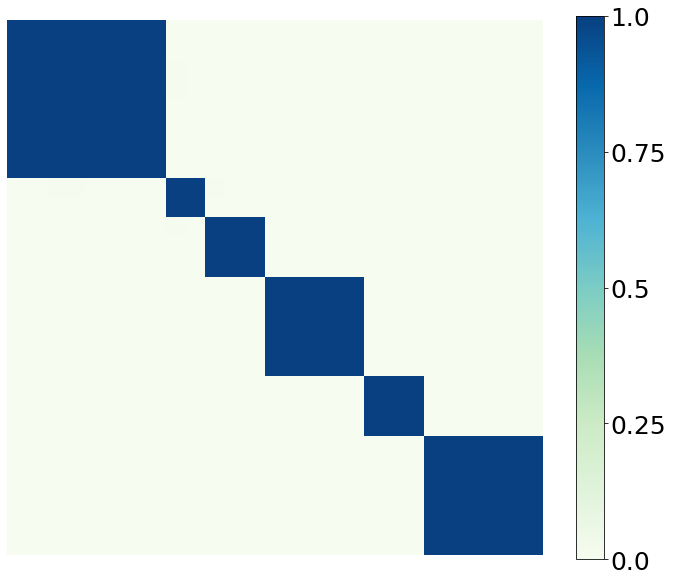

In [157]:
f = plt.figure(figsize=(12,10))
plt.imshow((F.normalize(X, p=2, dim=0).T @ F.normalize(X, p=2, dim=0)), cmap="GnBu", vmin=0.0, vmax=1.0)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=25)
cb.set_ticks(np.linspace(0, 1, 5))
cb.ax.set_yticklabels(np.linspace(0, 1, 5))
plt.axis("off")
f.savefig("./xx.pdf", bbox_inches='tight')

In [ ]:
concept_id = 0

mask = Y[concept_id,:] == 1
basis, svals, _ = torch.linalg.svd(Y[:,mask])
basis = basis[:,svals>1e-3]

concept_op = basis @ basis.T

print(svals)
print(basis)

print(embeddings[:,4].T @ concept_op @ embeddings[:,4])